In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numba
import random
from numba import jit
import time
import dask 
from dask import delayed
from collections import deque
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import pandas as pd

In [3]:
def circle_points(center, radius):
    """
    Calculate all points within a circle in a 2D grid using a rasterization approach,
    returning the points as an array of arrays.

    Parameters:
        center (tuple): The (x, y) coordinates of the circle's center.
        radius (int): Radius of the circle.
    
    Returns:
        list: A list of [x, y] points inside the circle.
    """
    cx, cy = center
    radius_squared = radius ** 2
    points = []

    # Use the midpoint circle algorithm to find points
    x, y = radius, 0
    decision = 1 - radius

    while x >= y:
        # Add the points for each octant of the circle as lists
        points.extend([
            [cx + x, cy + y], [cx - x, cy + y], [cx + x, cy - y], [cx - x, cy - y],
            [cx + y, cy + x], [cx - y, cy + x], [cx + y, cy - x], [cx - y, cy - x]
        ])

        y += 1
        if decision <= 0:
            decision += 2 * y + 1
        else:
            x -= 1
            decision += 2 * (y - x) + 1

    # Filter points to ensure they are within the bounds of the grid (optional)
    points = [list(item) for item in set(tuple(point) for point in points)]  # Remove duplicates
    return np.array(points)

In [4]:
@jit(nopython=True)
def _compute_gradient(pos_x, pos_y, u, dx, dy, step = 1):
    
    x, y = pos_x, pos_y 

    # Compute central difference gradient
    if 1 <= x < u.shape[0] - 1 and 1 <= y < u.shape[1] - 1: # boundary rejection

        grad_x = (u[x+step, y] - u[x-step, y]) / (2 * dx) # x grad
        grad_y = (u[x, y+step] - u[x, y-step]) / (2 * dy) # y grad
    
    else:
        grad_x, grad_y = 0, 0 
    
    return grad_x, grad_y

In [40]:
test = circle_points( (0,0),3)

In [41]:
test

array([[ 2, -2],
       [-3, -1],
       [ 0, -3],
       [ 3, -1],
       [-2, -2],
       [-3,  1],
       [ 3,  1],
       [ 0,  3],
       [-1, -3],
       [-3,  0],
       [ 3,  0],
       [-1,  3],
       [ 1, -3],
       [ 2,  2],
       [-2,  2],
       [ 1,  3]])

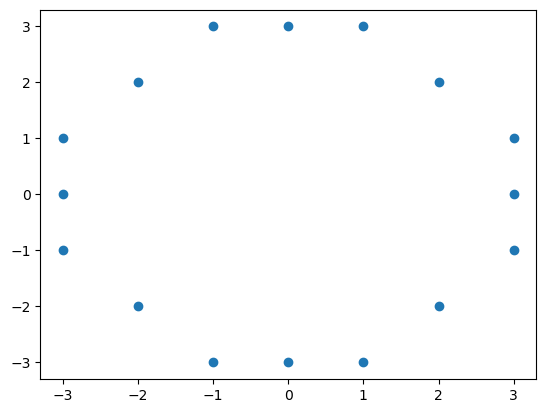

In [42]:
plt.scatter(test[:,0], test[:,1])

In [43]:
temp = test + [1,1] 

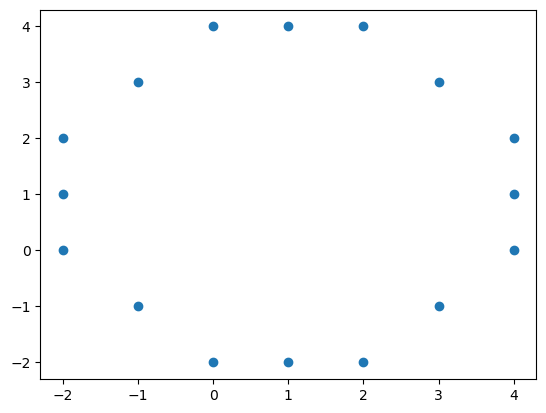

In [44]:
plt.scatter(temp[:,0], temp[:,1])

In [45]:
ex_grid = np.zeros((10,10))

In [46]:
lim_size = np.array(ex_grid.shape)

In [47]:
temp

array([[ 3, -1],
       [-2,  0],
       [ 1, -2],
       [ 4,  0],
       [-1, -1],
       [-2,  2],
       [ 4,  2],
       [ 1,  4],
       [ 0, -2],
       [-2,  1],
       [ 4,  1],
       [ 0,  4],
       [ 2, -2],
       [ 3,  3],
       [-1,  3],
       [ 2,  4]])

In [54]:
# Define the boundaries
x_min, x_max = 0, lim_size[0]
y_min, y_max = 0, lim_size[1]

# Filter points in temp that are outside the boundaries
outside_points = temp[(temp[:, 0] < x_min) | (temp[:, 0] >= x_max) | (temp[:, 1] < y_min) | (temp[:, 1] >= y_max)]
outside_points

array([[ 3, -1],
       [-2,  0],
       [ 1, -2],
       [-1, -1],
       [-2,  2],
       [ 0, -2],
       [-2,  1],
       [ 2, -2],
       [-1,  3]])

In [58]:
movement_vector = np.sum(-outside_points, axis = 0)

In [61]:
temp += movement_vector

In [62]:
# Define the boundaries
x_min, x_max = 0, lim_size[0]
y_min, y_max = 0, lim_size[1]

# Filter points in temp that are outside the boundaries
outside_points = temp[(temp[:, 0] < x_min) | (temp[:, 0] >= x_max) | (temp[:, 1] < y_min) | (temp[:, 1] >= y_max)]
outside_points

array([], shape=(0, 2), dtype=int64)

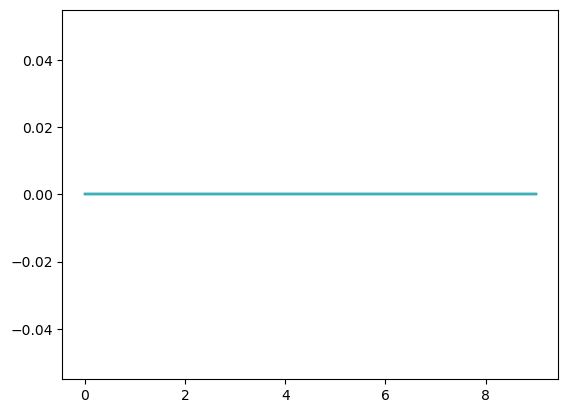

In [10]:
plt.plot(ex_grid)

In [8]:
class Cell_2():
    '''
    ----------------
    This class represents a cell that can move within a grid. 
    The cell's position is updated based on random movement and gradients computed from a given field. 
    The cell's position history is recorded and can be retrieved in either list, dataframe or dictionary format.
    
    Attributes:
    pos_x (int): x-coordinate of the cell 
    pos_y (int): y-coordinate of the cell   
    pos_history (deque): history of the cell's position
    shape (list): shape of the cell, options:
        [circle, radius],
        [rectangular / square , width, height],
    
    polarity:
    saturation coefficient:
    -----------

    ''' 
    def __init__(self, pos_x, pos_y, shape  = [ "circle", 1] ):

        self.default = True

        if shape[0] == "circle":

            self.default = False
            self.points = circle_points((pos_x, pos_y, shape[1]))

        self.shape = shape[0]
        self.pos_x = int(pos_x)
        self.pos_y = int(pos_y)
        self.pos_history = deque()
        self.pos_history.append([0,self.pos_x,self.pos_y])
    
    def update_pos(self, grid_size, step = 1):

        if self.default:
            self.pos_x = np.clip(self.pos_x + np.random.randint(-step, step), 0, grid_size - 1)
            self.pos_y = np.clip(self.pos_y + np.random.randint(-step, step), 0, grid_size - 1)
        else:
            self.points = np.clip(self.points + [np.random.randint(-step, step), np.random.randint(-step, step)], 0, grid_size - 1)


   # @jit(nopython = True)
    def compute_gradient(self, u, dx, dy, step = 1):
        
        grad_x, grad_y = _compute_gradient(self.pos_x, self.pos_y, u, dx, dy, step)
        return grad_x, grad_y
    
    #@jit(nopython = True)
    def update_pos_grad(self, u, dx, dy, sensitivity, time_curr, dt, step=1,):
        
        grad_x, grad_y = self.compute_gradient(u, dx, dy)

        rand_x = random.randint(-step, step)
        rand_y = random.randint(-step, step)

        # Scale gradient to influence movement
        move_x = rand_x + grad_x * sensitivity
        move_y = rand_y + grad_y * sensitivity

        # Update cell position with stochastic movement, ensuring it stays within bounds

        if self.default:
            self.pos_x = np.clip(self.pos_x + int(move_x), 0, u.shape[0] - 1)
            self.pos_y = np.clip(self.pos_y + int(move_y), 0, u.shape[1] - 1)

        else:
            self.points = np.clip(self.points + [move_x, move_y], 0, u.shape[0] - 1)
 

        self.pos_history.append([time_curr+dt, self.pos_x, self.pos_y])

    def get_position_history(self,type="list"):
        if type=="list":
            return list(self.pos_history)
        elif type == "df":
            df = pd.DataFrame ( list(self.pos_history), columns = ["time_step", "pos_x", "pos_y"]) 
            return df
        elif type == "dict":
            return { "time_step": [x[0] for x in self.pos_history], "pos_x": [x[1] for x in self.pos_history], "pos_y": [x[2] for x in self.pos_history]}
        

In [70]:
alpha = 400
length = 400
sim_time = 5
nodes = 250
num_cells= 8

dx = length / nodes
dy= length / nodes


dt = min(dx**2 / (4*alpha), dy**2 / (4/alpha))

t_nodes = int(sim_time/dt)

u = np.zeros((nodes, nodes))


array_len = len(u)

max_temp = 100

u[:,-1:-10] = max_temp
#u[:,int(nodes*0.75):]= max_temp
u[0:50,:] = max_temp
#u[ int(len(u)/2): int(len(u)/2)] = 100

center_x, center_y = nodes // 2, nodes // 2
radius = 15  # Radius of high temperature region

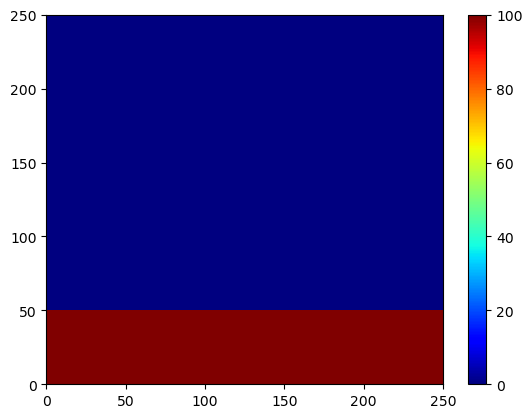

In [71]:
fig, axis = plt.subplots()
pcm = axis.pcolormesh(u, cmap = plt.cm.jet, vmin=0, vmax=100)
plt.colorbar(pcm, ax=axis)


In [72]:
cells = [Cell( int(nodes/ 2),int( nodes / 2)) for _ in range(num_cells)]
counter = 0 
cellMarker = []

@jit(nopython=True)
def calc_grad_np(u):
    w = u.copy()
    w[1:-1, 1:-1] = (
        u[1:-1, 1:-1]
        + alpha * dt * (
            (u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[:-2, 1:-1]) / dx**2
            + (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, :-2]) / dy**2
        )
    )
    return w

@delayed
def update_cell(c, u, dx, dy, counter, dt):
    c.update_pos_grad(u, dx, dy, 0.5, counter, dt)
    u[c.pos_x, c.pos_y] =  u[c.pos_x, c.pos_y] / 10
    return c

In [73]:
start = time.time()

while counter < sim_time : # O(t)

    w = u.copy()
    if cellMarker:
        for mark in cellMarker: # O(n)
            mark.remove()

    u = calc_grad_np(u)            
    
    tasks = [ delayed (update_cell)(c, u, dx, dy, counter, dt) for c in cells ]    
    results = dask.compute(*tasks)

  #  print("t: {:.3f} [s], Concentration {:.2f} %".format(counter, np.average(u)))

    pcm.set_array(u)
    axis.set_title("Distribution at t: {:.3f} [s].".format(counter))

    cellMarker = [axis.plot(cell.pos_y, cell.pos_x, 'wo', markersize=8)[0] for cell in cells]  

 
    #plt.pause(0.01)
    counter += dt
    
end = time.time()

FINAL = end - start

print(f'Total Execution Time: {FINAL}')

Total Execution Time: 6.125960350036621


In [74]:
test_cell1 = cells[0].get_position_history(type="df")

In [75]:
test_cell1

,time_step,pos_x,pos_y
0,0.0000,125,125
1,0.0016,125,125
2,0.0032,124,125
3,0.0048,125,124
4,0.0064,126,123
...,...,...,...
3122,4.9952,50,176
3123,4.9968,50,176
3124,4.9984,51,177
3125,5.0000,52,177


In [76]:
cell_0_pos_history = np.array(cells[0].get_position_history())
cell_1_pos_history = np.array(cells[1].get_position_history())
cell_2_pos_history = np.array(cells[2].get_position_history())
cell_3_pos_history = np.array(cells[3].get_position_history())


In [77]:
def plot_cell_history(cell_history):
    time_steps = cell_history [:,0]
    x_pos = cell_history [:,1]
    y_pos = cell_history [:,2]

    points = np.array([x_pos, y_pos]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection with color mapping
    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(time_steps.min(), time_steps.max()))
    lc.set_array(time_steps)
    lc.set_linewidth(2)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.gca().add_collection(lc)
    plt.plot(x_pos, y_pos, color='black', alpha=0.1)
    # Annotate start and end
    plt.scatter(x_pos[0], y_pos[0], color='green', label='Start', zorder=5)
    plt.scatter(x_pos[-1], y_pos[-1], color='red', label='End', zorder=5)

    plt.colorbar(lc, label='Time Step')
    plt.title("Cell Movement Trajectory with Gradient Line (Colored by Time Step)")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.grid(True)
    plt.legend()
    plt.show()

In [78]:

def plot_history_2(position_history, ax=None, color=None, cmap='viridis', label='Cell Path'):
    """
    Plots a cell's movement on a 2-Dimensional grid with a gradient line colored by time step

    Parameters:
    - position_history (np.ndarray): Array of shape (n, 3) where each row is [time_step, x, y].
    - ax (matplotlib.axes._axes.Axes, optional): Axis to plot on. If None, a new figure and axis are created.
    - cmap (str, optional): Colormap for the trajectory.
    - label (str, optional): Label for the cell trajectory.
    
    Returns:
    - fig (matplotlib.figure.Figure): The figure object.
    - ax (matplotlib.axes._axes.Axes): The axes object.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    # Extract time steps, x positions, and y positions
    time_steps = position_history[:, 0]
    x_positions = position_history[:, 1]
    y_positions = position_history[:, 2]

    # Create segments for LineCollection
    points = np.array([x_positions, y_positions]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection with color mapping
    lc = LineCollection(segments, cmap=cmap, norm=plt.Normalize(time_steps.min(), time_steps.max()))
    lc.set_array(time_steps)
    lc.set_linewidth(2)

    ax.add_collection(lc)
    ax.plot(x_positions, y_positions, color=color, alpha=0.3)  # Base path with markers for reference

    # Annotate start and end
    ax.scatter(x_positions[0], y_positions[0], label='Start', zorder=5)
    ax.scatter(x_positions[-1], y_positions[-1], label='End', zorder=5)

    ax.set_title("Cell Movement Trajectory with Gradient Line (Colored by Time Step)")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.grid(True)
    ax.legend()

    return fig, ax, lc

/var/folders/_4/kt858wtj2111y2396_n7rtsm0000gn/T/ipykernel_84006/2067441439.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('hsv', num_trajectories)


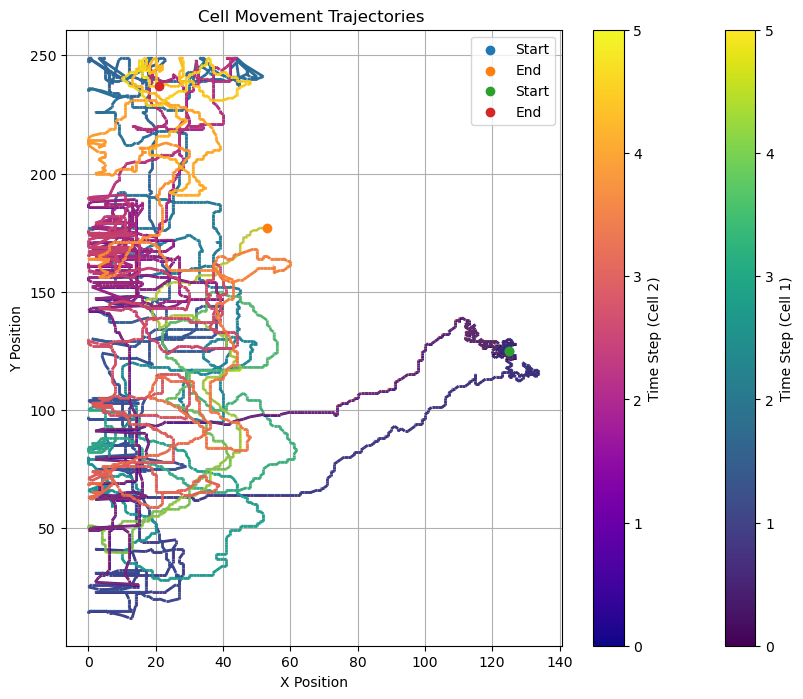

In [79]:
fig, ax = plt.subplots(figsize=(10,8))

trajectories = [cell_0_pos_history, cell_1_pos_history]

num_trajectories = len(trajectories)
colors = cm.get_cmap('hsv', num_trajectories)


colormaps = ['viridis', 'plasma']

for idx, traj in enumerate(trajectories):
    fig, ax, lc = plot_history_2(traj, ax=ax, cmap=colormaps[idx], label=f'Cell {idx + 1}')
    cbar = plt.colorbar(lc, ax=ax, label=f'Time Step (Cell {idx + 1})')
    cbar.set_label(f'Time Step (Cell {idx + 1})')
    
ax.legend()
plt.title("Cell Movement Trajectories ")
plt.show()

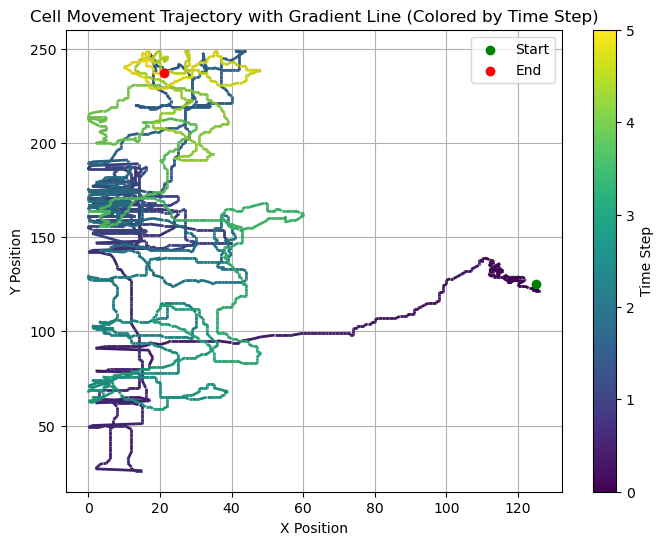

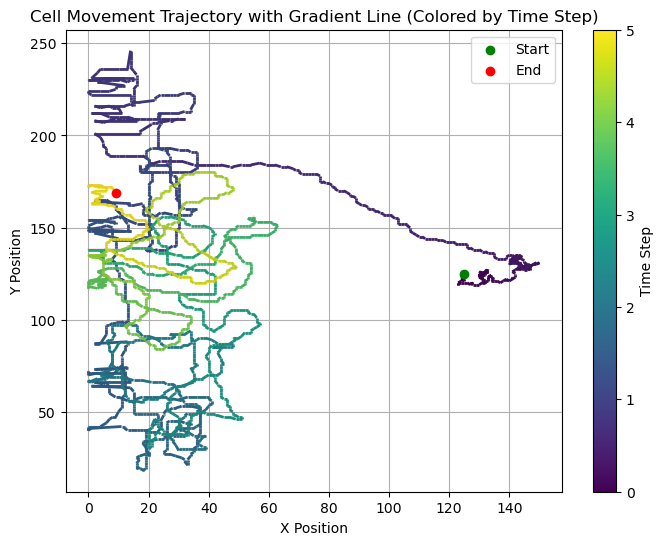

In [80]:
plot_cell_history(cell_1_pos_history)
plot_cell_history(cell_2_pos_history)

In [81]:
time_steps = cell_0_pos_history [:,0]
x_pos = cell_0_pos_history [:,1]
y_pos = cell_0_pos_history [:,2]

In [82]:
from matplotlib.collections import LineCollection

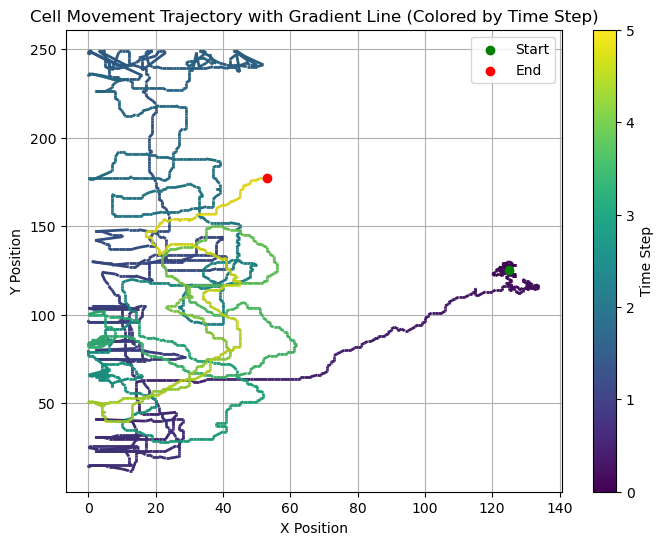

In [83]:
points = np.array([x_pos, y_pos]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection with color mapping
lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(time_steps.min(), time_steps.max()))
lc.set_array(time_steps)
lc.set_linewidth(2)

# Plot
plt.figure(figsize=(8, 6))
plt.gca().add_collection(lc)
plt.plot(x_pos, y_pos, color='black', alpha=0.1)
# Annotate start and end
plt.scatter(x_pos[0], y_pos[0], color='green', label='Start', zorder=5)
plt.scatter(x_pos[-1], y_pos[-1], color='red', label='End', zorder=5)

plt.colorbar(lc, label='Time Step')
plt.title("Cell Movement Trajectory with Gradient Line (Colored by Time Step)")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid(True)
plt.legend()
plt.show()

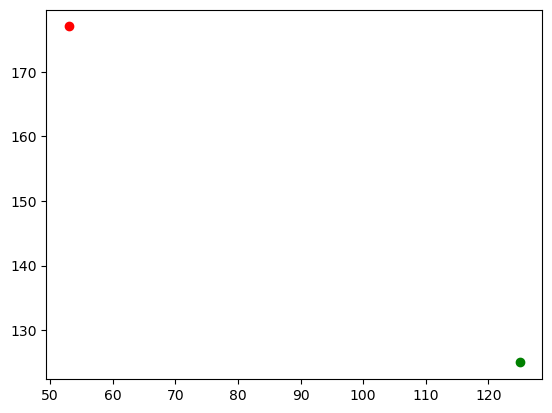

In [84]:
plt.scatter(x_pos[0], y_pos[0], color='green', label='Start', zorder=5)

plt.scatter(x_pos[-1], y_pos[-1], color='red', label='End', zorder=5)